# Autoencoder with NotMNIST dataset

上一篇我们已经了了解了 [Autoencoder in Keras](Autoencoder with Keras.ipynb), 并使用了 MNIST 数据集，这一章我们将再次实现 Autoencoder但用[NotMNISt 数据集](http://yaroslavvb.com/upload/notMNIST/)

## 目录
- [1. NotMNIST数据](#1.-NotMNIST数据)
- [2. 加载gzip数据](#2.-加载gzip数据)
- [3. 构建神经网络(CNN)](#3.-构建神经网络(CNN))
- [4. 添加噪点](#4.-添加噪点)


本章所使用的 loss函数为 '**mean_squared_error**', optimizer函数为 '**RMSprop**'

请参见 [优化方法总结(BGD,SGD,Momentum,AdaGrad,RMSProp,Adam)](https://blog.csdn.net/u014595019/article/details/52989301) 获得更多的关于 **RMSprop** 优化方法的信息!

# 1. NotMNIST数据

**MNIST**数据集我们都知道是 0-9 10个数的不同手写字体，那**NotMNIST**故名思意，则是非数字即字母的各种手写体
[NotMNIST数据 原数据集下载](http://yaroslavvb.com/upload/notMNIST/) (http://yaroslavvb.com/upload/notMNIST), 如果我们要用Keras或者TensorFlow来训练，原数据集显然是不行的(因为是图片)

**NotMNIST** 有 60000个训练数据，10000个测试数据 对应字母 (A, B, C, D, E, F, G, H, I, J) 这10个字母


[notMNIST-to-MNIST](https://github.com/davidflanagan/notMNIST-to-MNIST) (https://github.com/davidflanagan/notMNIST-to-MNIST) 这个里面的数据集便是已经处理过的 『ubyte.gz』本文会讲到如何加载 `gzip`的数据


可以执行以一命令下载，也可以浏览器下直接下载
```
curl -o train-images-idx3-ubyte.gz https://github.com/davidflanagan/notMNIST-to-MNIST/blob/master/train-images-idx3-ubyte.gz
curl -o train-labels-idx1-ubyte.gz https://github.com/davidflanagan/notMNIST-to-MNIST/blob/master/train-labels-idx1-ubyte.gz

curl -o t10k-images-idx3-ubyte.gz https://github.com/davidflanagan/notMNIST-to-MNIST/blob/master/t10k-images-idx3-ubyte.gz   
curl -o t10k-labels-idx1-ubyte.gz https://github.com/davidflanagan/notMNIST-to-MNIST/blob/master/t10k-labels-idx1-ubyte.gz    
   
```

# 2. 加载gzip数据

使用 `gzip` lib, 用 `bytestream.read()`来读取，再使用 `np.frombuffer()`, 代码如下:

In [1]:
import numpy as np
import gzip

def extra_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data

In [2]:
train_data = extra_data('../data/train-images-idx3-ubyte.gz', 60000)
test_data = extra_data('../data/t10k-images-idx3-ubyte.gz', 10000)

In [3]:
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
def extra_labels(filename, num_labels):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_labels)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
        return labels
        

In [5]:
train_lables = extra_labels('../data/train-labels-idx1-ubyte.gz', 6000)
test_labels = extra_labels('../data/t10k-labels-idx1-ubyte.gz', 1000)

In [6]:
print(train_lables.shape)
print(test_labels.shape)

(6000,)
(1000,)


Let's create a dictionary that will have class names with their corresponding categorical class labels:

In [7]:
# create dictionary of target classes
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J'
}

我们来看一下这些图片到底是什么

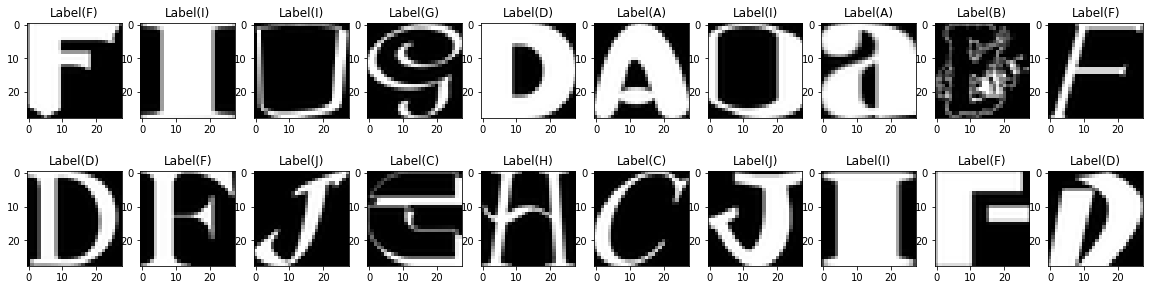

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,5))

n=10
for i in range(n):
    plt.subplot(2, n, i+1)
    curr_img = np.reshape(train_data[i], (28,28))
    curr_labe = train_lables[i]
    plt.imshow(curr_img, cmap='gray')
    plt.title('Label(' + str(label_dict[curr_labe]) + ")")
    
    plt.subplot(2, n, i+1+n)
    test_curr_img = np.reshape(test_data[i], (28, 28))
    test_curr_label = test_labels[i]
    plt.imshow(test_curr_img, cmap='gray')
    plt.title('Label(' + str(label_dict[test_curr_label]) + ')')

plt.show()

# 3. 构建神经网络(CNN)

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from sklearn.cross_validation import train_test_split


train_data = train_data.reshape(-1, 28,28,1)
test_data = test_data.reshape(-1, 28,28,1)
print train_data.shape
print test_data.shape

# 处理数据，将数据 between到  0.0 到 1.0之间
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

train_X, valid_X, train_ground, valid_ground = train_test_split(train_data, train_data, 
                                                                test_size=0.2, 
                                                                random_state=13)

print(train_X.shape, valid_X.shape)
print(train_ground.shape, valid_ground.shape)


/Users/yongliu/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/yongliu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(60000, 28, 28, 1)
(10000, 28, 28, 1)
((48000, 28, 28, 1), (12000, 28, 28, 1))
((48000, 28, 28, 1), (12000, 28, 28, 1))


In [45]:
input_img = Input(shape=(28,28, 1))

# encoder
conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) # 28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2,2))(conv1) # 14 x 14 x 32
conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1) # 14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2,2))(conv2) # 7 x 7 x 64
conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) # 7 x 7 x 128

# decoder
conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3) # 7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1

autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mse', optimizer=RMSprop())

autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 128)         147584    
__________

训练模型

In [11]:
autoencoder_train = autoencoder.fit(train_X, train_ground, epochs=10, 
                                    batch_size=128, 
                                    validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 204s 4ms/step - loss: 0.0334 - val_loss: 0.0136
Epoch 2/10
48000/48000 [==============================] - 219s 5ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 3/10
48000/48000 [==============================] - 213s 4ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 4/10
48000/48000 [==============================] - 213s 4ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/10
48000/48000 [==============================] - 210s 4ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 6/10
48000/48000 [==============================] - 206s 4ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/10
48000/48000 [==============================] - 214s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/10
48000/48000 [==============================] - 213s 4ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/10
48000/48000 [==============================] - 211s 4ms/step - loss: 0.0033 - val_loss: 0.0

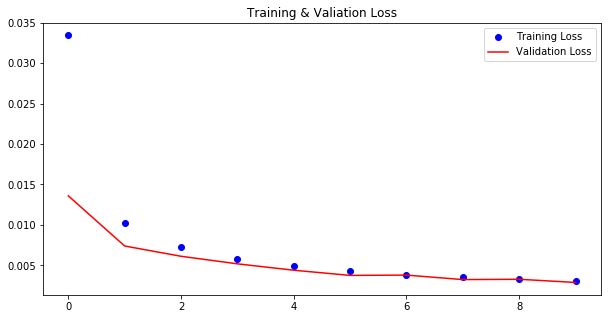

In [24]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']

plt.figure(figsize=(10,5))

x = range(10)
plt.plot(x, loss, 'bo',  label='Training Loss')
plt.plot(x, val_loss, 'b', label='Validation Loss', color='r')
plt.title('Training & Valiation Loss')
plt.legend()
plt.show()


**Trainging Loss** 在减小，且 **Validation Loss**也在减小，说明不会出现 **过拟合** 的情况，模型还是不错的！

In [25]:
pred = autoencoder.predict(test_data)

In [26]:
print pred.shape

(10000, 28, 28, 1)


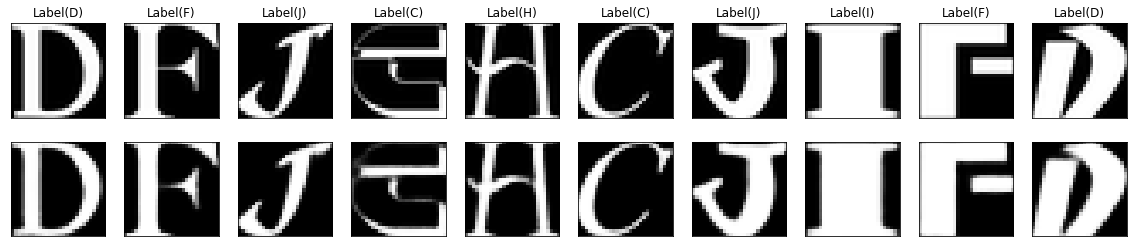

In [31]:
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(test_data[i,...,0], cmap='gray')
    cur_label=str(label_dict[test_labels[i]])
    plt.title('Label(%s)' % cur_label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(pred[i,...,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()    

效果还是不错的

# 4. 添加噪点

In [32]:
noise_factor = 0.5

train_X_noise = train_X + noise_factor * np.random.normal(loc=0., scale=1., size=train_X.shape)
valid_X_noise = valid_X + noise_factor * np.random.normal(loc=0., scale=1., size=valid_X.shape)

train_X_noise = np.clip(train_X_noise, 0., 1.0)
valid_X_noise = np.clip(valid_X_noise, 0., 1.0)

In [66]:
test_X_noise = test_data + noise_factor * np.random.normal(loc=0., scale=1., size=test_data.shape)
test_X_noise = np.clip(test_X_noise, 0., 1.)

In [33]:
train_X_noise.shape

(48000, 28, 28, 1)

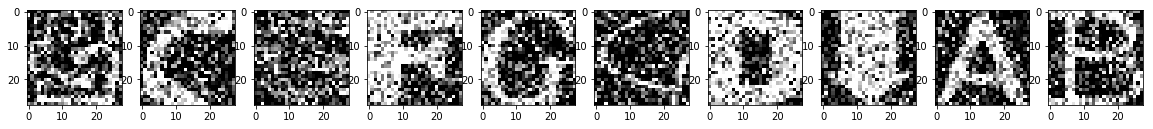

In [39]:
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(train_X_noise[i, ..., 0], cmap='gray')
    
plt.show()    

In [52]:
input_img = Input(shape=(28,28,1))

cov1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) # 28 x 28 x 32
pool1 = MaxPooling2D((2,2))(cov1) # 14 x 14 x 32
cov2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1) # 14 x 14 x 64
pool2 = MaxPooling2D((2,2))(cov2) # 7 x 7 x 64
cov3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) # 7 x 7 x 128

# define decoder
cov4 = Conv2D(128, (3,3), activation='relu', padding='same')(cov3) # 7 x 7 x 128
up1 = UpSampling2D((2,2))(cov4) # 14 x 14 x 128
cov5 = Conv2D(64, (3,3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(cov5) # 28 x 28 x 64
# decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mse', optimizer=RMSprop())

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 7, 7, 128)         147584    
__________

In [53]:
epochs = 5
batch_size = 128

autoencoder_train = autoencoder.fit(train_X_noise, train_X, epochs=epochs, batch_size=batch_size, 
                validation_data=(valid_X_noise, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 189s 4ms/step - loss: 0.0520 - val_loss: 0.0298
Epoch 2/5
48000/48000 [==============================] - 199s 4ms/step - loss: 0.0239 - val_loss: 0.0209
Epoch 3/5
48000/48000 [==============================] - 206s 4ms/step - loss: 0.0206 - val_loss: 0.0186
Epoch 4/5
48000/48000 [==============================] - 207s 4ms/step - loss: 0.0189 - val_loss: 0.0205
Epoch 5/5
48000/48000 [==============================] - 204s 4ms/step - loss: 0.0179 - val_loss: 0.0174


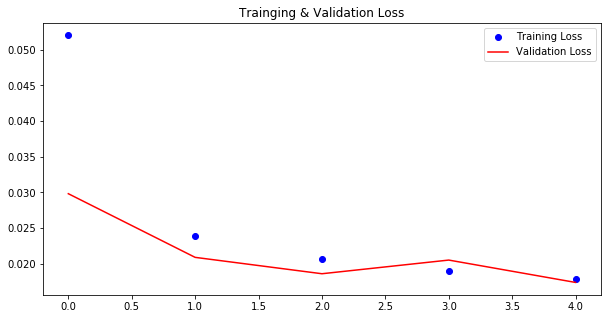

In [58]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']

x = range(epochs)
plt.figure(figsize=(10,5))
plt.plot(x, loss, 'bo', label='Training Loss', color='b')
plt.plot(x, val_loss, 'b', label='Validation Loss', color='r')
plt.title('Trainging & Validation Loss')
plt.legend()
plt.show()

In [60]:
decoded_imgs_noised = autoencoder.predict(test_X_noise)

original test data:


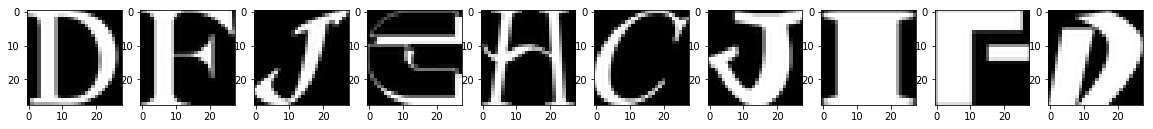

Added noise for test data:


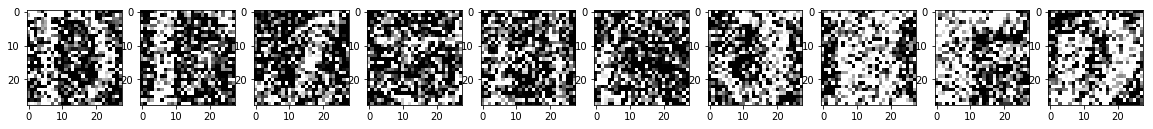

Decoded noised test data:


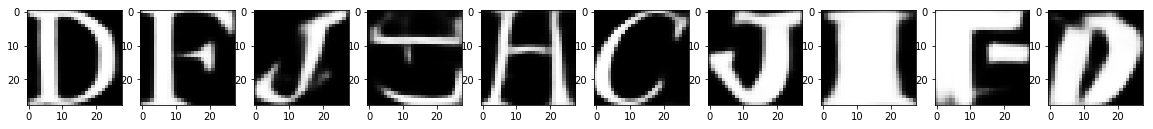

In [67]:
print 'original test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    
plt.show() 

print 'Added noise for test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(test_X_noise[i, ..., 0], cmap='gray')
    
plt.show()  

print 'Decoded noised test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(decoded_imgs_noised[i, ..., 0], cmap='gray')
    
plt.show()  



效果相当的不错

下面将 test data 的 noise 加多一点，看模型是否能decode出来


In [78]:
noise_factor = 0.7
test_X_noise = test_data + noise_factor * np.random.normal(loc=0., scale=1., size=test_data.shape)
test_X_noise = np.clip(test_X_noise, 0., 1.)

decoded_imgs_noised = autoencoder.predict(test_X_noise)

original test data:


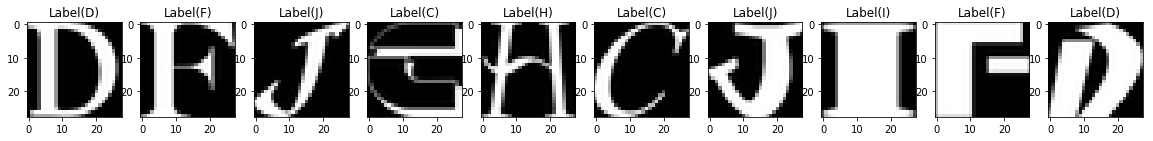

Added noise for test data:


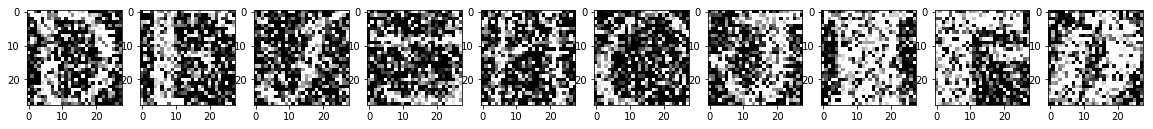

===> Decoded noised test data:


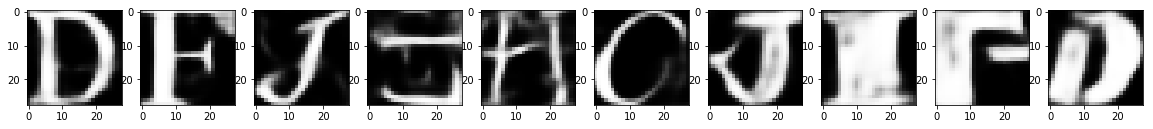

In [83]:
print 'original test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    cur_lable = str(label_dict[test_labels[i]])
    plt.title('Label(%s)' % cur_lable)
    
plt.show() 

print 'Added noise for test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(test_X_noise[i, ..., 0], cmap='gray')
    
plt.show()  

print '===> Decoded noised test data:'
plt.figure(figsize=(20,4))
n = 10
for i in range(n):
    plt.subplot(1,n, i+1)
    plt.imshow(decoded_imgs_noised[i, ..., 0], cmap='gray')
    
plt.show()  

 效果也还可以，毕竟通过人眼都很难识别的，但通过机器学习却可以识别出来大部分！！！
 

【参考】
- https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial